### Pixel Access and Cropping
Recall that pixels represent an ordered collection of measurements from a particular small region of Earth. Each band is a particular measurement and all pixels, for a particular band, have the same data being measured by that band. For example, in a color image of Earth, the first band typically measures the amount of light in the red wavelength range. That is the Red band, followed by Green and Blue.

Based on the ground sample distance (GSD) of pixels, any particular sub-raster (AKA tile, chip, sub-image) from a larger image covers an area of Earth that is a subset of the Earth from the larger raster. In this lab, we will access individual pixels and sub-rasters, as well as compute their coverage.

Number of bands: 10
Data Types: ('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')


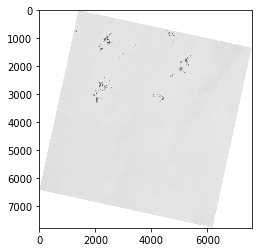

In [1]:
### Loading and Basic Visualization
import rasterio
import numpy as np
%matplotlib inline
from rasterio.plot import show

# Open, and visualize with a little Band and Datatype information
with rasterio.open('C:/Users/mac/Documents/Python_Rasterio/LC08_L1TP_169056_20190312_20190325_01_T1_Stack.tif') as raster_data:
    print("Number of bands: {}".format(raster_data.count))
    print("Data Types: {}".format(raster_data.dtypes))
    
    band1 = raster_data.read(1)
    rasterio.plot.show(band1, cmap='Greys')

### Examine the Spatial Characteristics

In [2]:
print(raster_data.crs)
print(" ------------")
print(raster_data.crs.wkt)

+init=epsg:32637
 ------------
PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32637"]]


In [3]:
raster_data.bounds

BoundingBox(left=176085.0, bottom=522885.0, right=404115.0, top=755715.0)

In [11]:
print(raster_data.bounds)

BoundingBox(left=176085.0, bottom=522885.0, right=404115.0, top=755715.0)


We see that this image is in "UTM zone 37N" and that the Top-Left position is expected to be:
(X=_______ , Y=___________)

In the CRS, we see the unit of measure is: UNIT["metre",1,AUTHORITY["EPSG","9001"]] ... meaning meters!

So, the Upper-Left is over _______ KM away (to the right) from the centeral meridian (center vertical line) of the projection. It is also nearly _____________ KM north of the projection's equator (center horizontal line).

Affine Transform
The Affine Transform maps a raster's pixels from pixel cooridinate space (X,Y) with Y growing larger as you move down the raster to CRS coordinates (typically Y growing larger as you move North).

(More Mathy) - http://mathworld.wolfram.com/AffineTransformation.html
(Slightly Less Mathy) - https://en.wikipedia.org/wiki/Affine_transformation

In [7]:
#print(raster_data.affine)

The affine transform matrix allow us to use simple Python math operations to determine the position of a pixel on Earth that is selected from the raster.

You will notice in the affine matrix above that the Upper-Left is represented as the first two rows of the right-most column. Therefore, if we multiply the raster size by the affine, e.g., affine * size, we should get the lower-right coordinates.

In [8]:
raster_dims_xy = (raster_data.width, raster_data.height)

print("Compare Raster Dims from Above: {}".format(raster_dims_xy))
print("---------------------------------------------------------")
print("To Internal Raster Shape: {}".format(raster_data.shape))

Compare Raster Dims from Above: (7601, 7761)
---------------------------------------------------------
To Internal Raster Shape: (7761, 7601)


Note: In square rasters this is not a problem, however under the hood the RasterIO library is using NumPy ND-Arrays and so major (first) index is Y or Row, not X or Column.

In [14]:
#lower_right = raster_data.affine * raster_dims_xy
#print("Lower-Right: {}".format(lower_right))

#print("----------- COMPARE TO BOUNDS ------------------------")
#print(raster_data.bounds)

So, if I want to know the position of the center (approximate)

In [16]:
#raster_center_xy = (raster_data.width/2, raster_data.height/2)
#center = raster_data.affine * raster_center_xy
#print("Center: {}".format(center))

### Reading values from the Raster
Any arbitrary pixel or window of pixels (sub-raster) can be accessed from the raster. This can be done in two ways:

Loading all the data, accessing the band, then using NumPy indexing to access values.
Using the RasterIO window options to pull out sub-rasters

### NumPy pixel value access

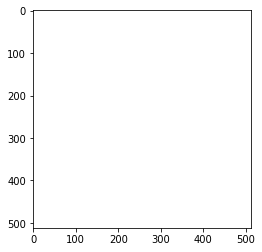

In [17]:
# NumPy Sub-array access
numpy_window = band1[256:768,256:768]

rasterio.plot.show(numpy_window, cmap='Greys')

In [18]:
pixel_c = band1[512,512]
print("Center-ish pixel value = {}".format(pixel_c))

pixel_other = band1[200,512]
print("Other pixel value = {}".format(pixel_other))

Center-ish pixel value = 0
Other pixel value = 0


### Sub-windows
A window is defined as follows:
((row_start, row_stop), (col_start, col_stop))

The window is then an argument to the RasterIO dataset's band reading function.

In [19]:
# Center Cropping, Y
y_size = raster_data.height
y_chip_base = raster_data.height/4 # go 1/4 down
y_chip_size = raster_data.height/2 # get sub-raster half height of original

# Center Cropping, X
x_size = raster_data.width
x_chip_base = raster_data.width/4 # go 1/4 to the right
x_chip_size = raster_data.width/2 # get sub-raster half width of original

# Buid our Window from base of window plus window size
y_range = (y_chip_base, y_chip_base + y_chip_size)  # defining a tuple
x_range = (x_chip_base, x_chip_base + x_chip_size)  # definign a tuple

subraster_window = (y_range, x_range)
print(subraster_window)

((1940.25, 5820.75), (1900.25, 5700.75))


Ponder
Geospatial raster files can exceed a billion pixels, e.g., a 1000 megapixel image. Often, this may be memory prohibitive on a computing system you are using. To get around the resource limits, you can use the Window-based access to rasters to read and then analyze/process/write a series of subrasters using Python loop constructs.